## Çok Sınıflı Sınıflandırma

Bu not defteri boyunca birçok kez CNN Explainer web sitesindeki TinyVGG mimarisine başvurduk, ancak CNN Explainer web sitesi 10 farklı görüntü sınıfıyla çalışırken, mevcut modelimiz yalnızca iki sınıfla (pizza ve biftek) çalışıyor.

> 🛠 **Uygulama:** Aşağı kaydırmadan önce, modelimizi aynı tür görüntülerden oluşan 10 sınıfla çalışacak şekilde nasıl değiştirebileceğimizi düşünüyorsunuz? Verilerin iki sınıflı problemimizle aynı tarzda olduğunu varsayın.

Pizza 🍕 vs. biftek 🥩 sınıflandırıcımızı oluşturmak için daha önce attığımız adımları hatırlıyor musunuz?

Bu adımları tekrar atmaya ne dersiniz, ancak bu sefer 10 farklı yiyecek türü ile çalışacağız.

1. Verilerle bir olun (görselleştirin, görselleştirin, görselleştirin...)
2. Veriyi ön işleme tabi tutun (model için hazırlayın)
3. Bir model oluşturun (bir taban çizgisi ile başlayın)
4. Modeli uygun hale getirin
5. Modeli değerlendirin
6. Farklı parametreleri ayarlayın ve modeli iyileştirin (temel çizginizi geçmeye çalışın)
7. Tatmin olana kadar tekrarlayın

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*Birazdan göreceğiniz iş akışı, yukarıdaki resmin biraz değiştirilmiş bir versiyonudur. Derin öğrenme problemlerini incelemeye devam ettikçe, yukarıdaki iş akışının adım adım bir kılavuzdan çok bir taslak olduğunu göreceksiniz.

### 1. Verileri içe aktarın ve verilerle bütünleşin

Yine, [Food101 veri kümesinin] bir alt kümesine sahibiz (https://www.kaggle.com/dansbecker/food-101). Pizza ve biftek görüntülerine ek olarak, sekiz sınıf daha çıkardık.


In [2]:
import zipfile

# # Download zip file of 10_food_classes images
# # See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

Şimdi `10_food_classes` dosyasındaki tüm farklı dizinleri ve alt dizinleri kontrol edelim.

In [3]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

İyi görünüyor!

Şimdi eğitim ve test dizini yollarını ayarlayacağız.

In [4]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

Ve alt dizinlerden sınıf adlarını alın.

In [5]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


How about we visualize an image from the training set?

In [12]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


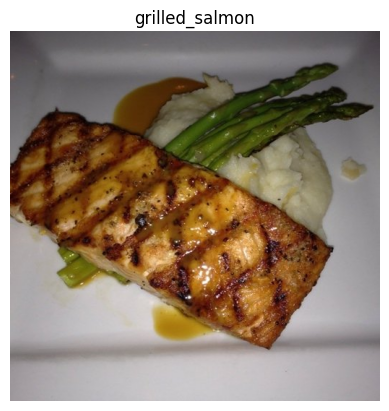

In [8]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Verileri ön işleme tabi tutun (bir model için hazırlayın)

Bir avuç görüntüyü inceledikten sonra (en az 10-100 farklı örneği görselleştirmek iyidir), veri dizinlerimiz doğru şekilde kurulmuş gibi görünüyor.

Verileri ön işleme zamanı.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


İkili sınıflandırmada olduğu gibi, yaratıcı görüntü oluşturucularımız var. Bu seferki ana değişiklik `class_mode' parametresini `'categorical'' olarak değiştirmiş olmamız çünkü 10 sınıf gıda görüntüsüyle uğraşıyoruz.

Görüntüleri yeniden ölçeklendirmek, toplu iş boyutunu ve hedef görüntü boyutunu oluşturmak gibi diğer her şey aynı kalır.

> 🤔 **Soru:** Görüntü boyutu neden 224x224? Bu aslında istediğimiz herhangi bir boyut olabilir, ancak 224x224 görüntülerin ön işlenmesi için çok yaygın bir boyuttur. Probleminize bağlı olarak daha büyük veya daha küçük görüntüler kullanmak isteyebilirsiniz.

### 3. Bir model oluşturun (bir taban çizgisi ile başlayın)

İkili sınıflandırma problemi için kullandığımız aynı modeli (TinyVGG) birkaç küçük değişiklikle çok sınıflı sınıflandırma problemimiz için de kullanabiliriz.

Şöyle ki
* Çıkış katmanını 10 çıkış nöronu kullanacak şekilde değiştirmek (sahip olduğumuz sınıf sayısı ile aynı sayı).
* Çıktı katmanını `'sigmoid'' aktivasyonu yerine `'softmax'' aktivasyonunu kullanacak şekilde değiştirmek.
* Kayıp fonksiyonunun "binary_crossentropy" yerine "categorical_crossentropy" olarak değiştirilmesi.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. Bir model uydurun

Artık birden fazla sınıfla çalışmaya uygun bir modelimiz var, şimdi bunu verilerimize uyarlayalım.

In [1]:
# use GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [21]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
  3/235 [..............................] - ETA: 9:59 - loss: 2.2333 - accuracy: 0.1771 

KeyboardInterrupt: 

Sizce neden her bir dönem sadece iki görüntü sınıfıyla çalıştığımız döneme kıyasla daha uzun sürüyor?

Çünkü artık daha önce olduğundan daha fazla görüntüyle uğraşıyoruz. Her biri 750 eğitim görüntüsü ve 250 doğrulama görüntüsü olmak üzere toplam 10.000 görüntü içeren 10 sınıfımız var. İki sınıfımız olduğunda ise 1500 eğitim görüntüsü ve 500 doğrulama görüntüsü olmak üzere toplam 2000 görüntümüz vardı.

Buradaki sezgisel mantık, ne kadar çok veriye sahip olursanız, bir modelin kalıpları bulmasının o kadar uzun süreceği yönündedir.

### 5. Modeli değerlendirin

Woohoo! Az önce bir modeli 10 farklı sınıftan gıda görüntüsü üzerinde eğittik, bakalım nasıl gitmiş.

In [ ]:
# Evaluate on the test data
model_9.evaluate(test_data)

In [ ]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)

Vay be, eğitim ve doğrulama kaybı eğrileri arasında oldukça büyük bir fark var.

Bu bize ne anlatıyor?

Görünüşe göre modelimiz eğitim setine oldukça kötü bir şekilde **aşırı uyum** sağlıyor. Başka bir deyişle, eğitim verilerinde harika sonuçlar elde ediyor, ancak görülmeyen verilere iyi genelleme yapamıyor ve test verilerinde kötü performans gösteriyor.

### 6. Model parametrelerini ayarlayın

Eğitim verilerindeki performansı nedeniyle modelimizin bir şeyler öğrendiği açıktır. Ancak, eğitim verilerinde iyi performans göstermek, sınıfta iyi olmak ancak becerilerinizi gerçek hayatta kullanamamak gibidir.

İdeal olarak, modelimizin test verilerinde de eğitim verilerinde olduğu kadar iyi performans göstermesini isteriz.

Bu yüzden sonraki adımlarımız modelimizin aşırı uyum sağlamasını engellemeye çalışmak olacaktır. Aşırı uyumu önlemenin birkaç yolu şunlardır:

- Daha fazla veri elde edin** - Daha fazla veriye sahip olmak, modele yeni örneklere daha fazla genellenebilecek kalıpları öğrenmek için daha fazla fırsat verir.
- Modeli basitleştirin** - Mevcut model zaten eğitim verilerine aşırı uyum sağlıyorsa, çok karmaşık bir model olabilir. Bu, veri kalıplarını çok iyi öğrendiği ve görülmemiş verilere iyi genelleme yapamadığı anlamına gelir. Bir modeli basitleştirmenin bir yolu, kullandığı katman sayısını azaltmak veya her katmandaki gizli birim sayısını azaltmaktır.
- Veri artırımını kullanın** - Veri artırımı, eğitim verilerini, verilere yapay olarak daha fazla çeşitlilik eklediği için modelin öğrenmesini zorlaştıracak şekilde manipüle eder. Bir model artırılmış verilerdeki örüntüleri öğrenebilirse, model görünmeyen verilere daha iyi genelleme yapabilir.
- Transfer öğrenimini kullanın** - Transfer öğrenimi, bir modelin kendi göreviniz için temel olarak kullanmak üzere öğrendiği kalıplardan (önceden eğitilmiş ağırlıklar olarak da adlandırılır) yararlanmayı içerir. Bizim durumumuzda, çok çeşitli görüntüler üzerinde önceden eğitilmiş bir bilgisayarla görme modelini kullanabilir ve daha sonra onu yiyecek görüntüleri için daha özel olacak şekilde biraz değiştirebiliriz.

> 🔑 **Not:** Aşırı uyumun önlenmesi **düzenleme** olarak da adlandırılır.

Zaten mevcut bir veri setiniz varsa, muhtemelen önce yukarıdaki son üç seçenekten birini veya bir kombinasyonunu deneyeceksiniz.

Daha fazla veri toplamak için elle daha fazla yiyecek fotoğrafı çekmemiz gerekeceğinden, doğrudan not defterinin içinden yapabileceklerimizi deneyelim.

Önce modelimizi basitleştirmeye ne dersiniz?

Bunu yapmak için konvolüsyonel katmanlardan ikisini kaldırarak toplam konvolüsyonel katman sayısını dörtten ikiye indireceğiz.
*** Translated with www.DeepL.com/Translator (free version) ***



In [ ]:
# Try a simplified model (removed two layers)
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

In [ ]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

Hmm... basitleştirilmiş bir modelle bile, modelimiz hala eğitim verilerine önemli ölçüde fazla uyuyor gibi görünüyor.

Başka ne deneyebiliriz?

Veri artırımına** ne dersiniz?

Veri artırımı, modelin eğitim verisi üzerinde öğrenmesini zorlaştırır ve bunun karşılığında öğrendiği kalıpları görünmeyen verilere daha genelleştirilebilir hale getirir.

Artırılmış veri oluşturmak için, yeni bir [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) örneğini yeniden oluşturacağız ve bu kez görüntülerimizi manipüle etmek için `rotation_range` ve `horizontal_flip` gibi bazı parametreler ekleyeceğiz.

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Artık artırılmış verilerimiz var, şimdi daha önce olduğu gibi aynı modelle (`model_10`) nasıl çalıştığını görelim.

Modeli sıfırdan yeniden yazmak yerine, TensorFlow'da mevcut bir modeli alıp aynı formatta yeniden oluşturabilen [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) adlı kullanışlı bir işlevi kullanarak onu klonlayabiliriz. 

Klonlanmış versiyon, orijinal modelin öğrendiği ağırlıkların (kalıpların) hiçbirini içermeyecektir. Yani onu eğittiğimizde, sıfırdan bir model eğitmiş gibi olacağız.

> 🔑 **Not:** Derin öğrenme ve genel olarak makine öğrenimindeki temel uygulamalardan biri **seri deneyci olmaktır**. Biz de burada bunu yapıyoruz. Bir şey denemek, işe yarayıp yaramadığını görmek, sonra başka bir şey denemek. İyi bir deney düzeneği, değiştirdiğiniz şeylerin kaydını da tutar, örneğin, bu yüzden daha önce olduğu gibi aynı modeli ancak farklı verilerle kullanıyoruz. Model aynı kalıyor ancak veriler değişiyor, bu bize artırılmış eğitim verilerinin performans üzerinde herhangi bir etkisi olup olmadığını bildirecektir.

In [ ]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Her dönemin bir önceki modelden daha uzun sürdüğünü görebilirsiniz. Bunun nedeni, verilerimizin GPU'ya yüklenirken CPU'da anında artırılması ve dolayısıyla her bir dönem arasındaki sürenin artmasıdır.

> Not:** Alınan bu süreyi iyileştirmenin bir yolu, artırma katmanlarını doğrudan modelin bir parçası olarak kullanmaktır. Örneğin, [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) ile. Ayrıca daha yeni [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) görüntü yükleme API'si ile veri yüklemeyi hızlandırabilirsiniz (bunu kursun ilerleyen bölümlerinde ele alacağız).

Modelimizin eğitim eğrileri nasıl görünüyor?

In [ ]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

Woah! Bu çok daha iyi görünüyor, kayıp eğrileri birbirine çok daha yakın. Modelimiz artırılmış eğitim setinde o kadar iyi performans göstermese de, doğrulama veri setinde çok daha iyi performans gösterdi.

Hatta daha uzun süre (daha fazla epok) eğitmeye devam edersek değerlendirme metrikleri iyileşmeye devam edebilir gibi görünüyor.

### 7. Tatmin olana kadar tekrarlayın

Burada devam edebiliriz. Modelimizin mimarisini yeniden yapılandırabilir, daha fazla katman ekleyebilir, deneyebilir, öğrenme oranını ayarlayabilir, deneyebilir, farklı veri artırma yöntemleri deneyebilir, daha uzun süre eğitim yapabiliriz. Ancak tahmin edebileceğiniz gibi, bu oldukça uzun bir zaman alabilir.

Neyse ki henüz denemediğimiz bir numara var ve o da **transfer öğrenme**.

Ancak bunu, kendi modellerimizi sıfırdan tasarlamak yerine başka bir modelin öğrendiği kalıplardan kendi görevimiz için nasıl yararlandığımızı göreceğiniz bir sonraki not defterine saklayacağız.

Bu arada, eğitilmiş çok sınıflı modelimizle bir tahmin yapalım.

## Eğitilmiş modelimizle bir tahmin yapmak

Tahmin yapamadığınız bir model ne işe yarar ki?

Öncelikle çok sınıflı modelimizin eğitildiği sınıfları kendimize hatırlatalım ve ardından üzerinde çalışmak için kendi özel görüntülerimizden bazılarını indirelim.

In [ ]:
# What classes has our model been trained on?
class_names

Güzel, şimdi bazı özel görsellerimizi alalım.

Google Colab kullanıyorsanız, dosyalar sekmesi aracılığıyla kendi görsellerinizden bazılarını da yükleyebilirsiniz.

In [ ]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

Tamam, denemek için bazı özel resimlerimiz var, resimlerden birinde `model_11` ile bir tahmin yapmak ve bunu çizmek için `pred_and_plot` işlevini kullanalım.

In [ ]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

Hmm... it looks like our model got the prediction wrong, how about we try another?

In [ ]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

Ve yine, bir sebepten dolayı `chicken_curry` olarak tahmin ediliyor.

Bir taneye daha ne dersin?

In [ ]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

Yine mi `chicken_curry`? Bir sorun olmalı...

Sanırım bu bizim `pred_and_plot` fonksiyonumuzla ilgili olabilir.

Fonksiyonu kullanmadan bir tahmin yapalım ve nerede yanlış gidiyor olabileceğini görelim.

In [ ]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Çok daha iyi! Bizim `pred_and_plot' fonksiyonumuzda bir sorun olmalı.

Ve sanırım ne olduğunu biliyorum.

Pred_and_plot` fonksiyonu ikili sınıflandırma modellerinde kullanılmak üzere tasarlanmıştır, oysa bizim mevcut modelimiz çok sınıflı bir sınıflandırma modelidir.

Temel fark `predict` fonksiyonunun çıktısında yatmaktadır.

In [ ]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

Modelimiz bir `'softmax'' aktivasyon fonksiyonuna ve 10 çıkış nöronuna sahip olduğundan, modelimizdeki sınıfların her biri için bir tahmin olasılığı çıkarır.

En yüksek olasılığa sahip sınıf, modelin görüntünün içerdiğine inandığı sınıftır.

Maksimum değer indeksini [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) kullanarak bulabilir ve ardından bunu `class_names` listemizi indekslemek ve tahmin edilen sınıfın çıktısını almak için kullanabiliriz.

In [ ]:
# Find the predicted class name
class_names[pred.argmax()]

Bunu bilerek, `pred_and_plot` fonksiyonumuzu ikili sınıfların yanı sıra çoklu sınıflarla da çalışacak şekilde yeniden ayarlayabiliriz.

In [ ]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Hadi deneyelim. Eğer doğru yaptıysak, farklı resimler kullanmak farklı çıktılara yol açmalıdır (her seferinde `chicken_curry` yerine).

In [ ]:
pred_and_plot(model_11, "03-steak.jpeg", class_names)

In [ ]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

In [ ]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

In [ ]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

Modelimizin tahminleri çok iyi değil, bunun nedeni test veri kümesinde yalnızca ~%35 doğrulukta performans göstermesidir.

Bunu nasıl geliştireceğimizi daha sonra göreceğiz (spolier: [transfer öğrenimi](https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/) işleri bir adım öteye taşıyacak).

## Modelimizi kaydetme ve yükleme

Bir modeli eğittikten sonra, muhtemelen onu kaydedebilmek ve başka bir yere yükleyebilmek istersiniz.

Bunu yapmak için [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) ve [`load_model`](https://www.tensorflow.org/tutorials/keras/save_and_load) fonksiyonlarını kullanabiliriz.

In [ ]:
# Save a model
model_11.save("saved_trained_model")

In [ ]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

In [ ]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

## 🛠 Alıştırmalar

1. CNN açıklayıcı web sitesini] (https://poloclub.github.io/cnn-explainer/) okuyarak ve etkileşimde bulunarak 20 dakika geçirin. 
 * Anahtar terimler nelerdir? Örneğin konvolüsyonu kendi kelimelerinizle, havuzlamayı kendi kelimelerinizle açıklayın

2. CNN explainer] (https://poloclub.github.io/cnn-explainer/) web sitesindeki "understanding hyperparameters" bölümüyle 10 dakika boyunca oynayın.
  * Çekirdek boyutu nedir?
  * Adım sayısı nedir? 
  * Bunların her birini TensorFlow kodunda nasıl ayarlayabilirsiniz?

3. İki farklı şeyin 10 fotoğrafını çekin ve burada oluşturduğumuz teknikleri kullanarak kendi CNN görüntü sınıflandırıcınızı oluşturun.

4. Basit bir evrişimsel sinir ağı modeli için 10 sınıflı veri setinizde ideal bir öğrenme oranı bulun.

## 📖 Extra-curriculum

1. **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.

2. **Watch:** Deep dive on [mini-batch gradient descent](https://youtu.be/-_4Zi8fCZO4) by deeplearning.ai. If you're still curious about why we use **batches** to train models, this technical overview covers many of the reasons why.

3. **Read:** [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) class notes. This will give a very deep understanding of what's going on behind the scenes of the convolutional neural network architectures we're writing. 

4. **Read:** ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf). This paper goes through all of the mathematics running behind the scenes of our convolutional layers.

5. **Code practice:** [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). For a more in-depth introduction on data augmentation with TensorFlow, spend an hour or two reading through this tutorial.